## Setting Up the Environment

First, let's import the necessary libraries and configure the environment.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import mne
import yaml
from pathlib import Path
import logging
import importlib

# Add the parent directory to path to import custom modules
sys.path.append(os.path.abspath('../..'))

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('fivepoint_pipeline')

# MNE settings
mne.set_log_level('INFO')
%matplotlib inline

## Loading the Pipeline Configuration

We'll load the minimal pipeline configuration from the YAML file.

In [2]:
# Load the minimal pipeline configuration
config_path = '../../configs/fivepoint_pipeline.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"Loaded configuration from {config_path}")

print("Pipeline steps:")
for step in config['pipeline']['steps']:
    print(f"- {step['name']}")

# Extract key configuration parameters
root_dir = config['directory']['root']
raw_data_dir = os.path.join(root_dir, config['directory']['raw_data_dir'])
processed_dir = os.path.join(root_dir, config['directory']['processed_dir'])
file_pattern = config['file_path_pattern']

# Ensure directories exist
os.makedirs(processed_dir, exist_ok=True)

Loaded configuration from ../../configs/fivepoint_pipeline.yml
Pipeline steps:
- LoadData
- PrepChannelsStep
- FilterStep
- EpochingStep
- SaveCheckpoint


## Step 1: Loading the Data

The first step is to load the raw EEG data. For Go/No-Go tasks, we expect the data to be in FIFF format.

In [3]:
# Step 1: Loading the Data
# Extract loading parameters from the configuration
load_data_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'LoadData')

# Construct the file path
file_path = os.path.join(raw_data_dir, file_pattern)

# Import and use the LoadData class from the pipeline
from scr.steps.load import LoadData

# Create and apply the load data step
logger.info(f"Loading data using LoadData")
load_data_step = LoadData(params=load_data_config.get('params', {}))

# For LoadData step, we pass the file path in the params
load_params = load_data_step.params.copy()
load_params["input_file"] = file_path
load_data_step.params = load_params

raw = load_data_step.run(None)

# Display basic information about the raw data
print("\nRaw data information:")
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.2f} seconds")

%matplotlib TkAgg

# Plot the raw data (first 10 seconds)
# raw.plot(duration=10, n_channels=20, title='Raw EEG data')

2025-08-26 16:04:40,656 - root - INFO - [ICAExtractionStep] Qt version: 5.15.2
2025-08-26 16:04:40,997 - numexpr.utils - INFO - NumExpr defaulting to 16 threads.
2025-08-26 16:04:41,685 - root - INFO - [__init__.py] All step classes have been registered in STEP_REGISTRY.
2025-08-26 16:04:41,687 - fivepoint_pipeline - INFO - Loading data using LoadData


Extracting EDF parameters from e:\Yann\neurotheque_resources\data\pilot_data\sub-01_ses-001_task-5pt_run-01_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96599  =      0.000 ...   321.997 secs...

Raw data information:
Number of channels: 27
Sampling frequency: 300.0 Hz
Duration: 322.00 seconds


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Channels marked as bad:
none


## Step 2: Channel Preparation

The `PrepChannelsStep` handles channel renaming, type setting, and montage application.

In [4]:
# Step 2: Channel Preparation
# Extract parameters from the configuration
prep_channels_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'PrepChannelsStep')

# Set the referencing parameters
if 'params' not in prep_channels_config:
    prep_channels_config['params'] = {}
    
prep_channels_config['params']['reference'] = {
    'method': 'average',  # Change from Pz (channels) to average reference
    'projection': False
}

# Force reload the module to ensure we have the latest version
import scr.steps.prepchannels
importlib.reload(scr.steps.prepchannels)

# Use the PrepChannelsStep with referencing
from scr.steps.prepchannels import PrepChannelsStep

# Create and apply the channel preparation step
logger.info(f"Preparing channels with referencing")
prep_channels_step = PrepChannelsStep(params=prep_channels_config['params'])
raw = prep_channels_step.run(raw)

# Print channel names after prep to verify ECG channel was dropped
print("\nChannel names after preparation:")
print(raw.ch_names)

2025-08-26 16:04:42,728 - fivepoint_pipeline - INFO - Preparing channels with referencing
2025-08-26 16:04:42,729 - root - INFO - [PrepChannelsStep] Running with params: {'on_missing': 'ignore', 'reference': {'method': 'average', 'projection': False}}
2025-08-26 16:04:42,739 - root - INFO - Dropped non-EEG: ['EEG X1:-Pz', 'EEG X2:-Pz', 'EEG X3:-Pz', 'CM', 'EEG A1-Pz', 'EEG A2-Pz', 'Event']
2025-08-26 16:04:42,741 - root - INFO - Renamed 18 EEG channels
e:\Yann\neurotheque_resources\scr\steps\prepchannels.py:53: RuntimeWarning: The unit for channel(s) Trigger has changed from NA to V.
  data.set_channel_types({ch: 'stim'})
2025-08-26 16:04:42,744 - root - INFO - Channel types set: 19 EEG, 1 STIM, 0 MISC
2025-08-26 16:04:42,745 - root - INFO - [PrepChannelsStep] Applying re-referencing with params: {'method': 'average', 'projection': False}
2025-08-26 16:04:42,746 - root - INFO - [apply_reference] Re-referencing method=average, projection=False
2025-08-26 16:04:42,747 - root - INFO - [ap

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


2025-08-26 16:04:42,770 - root - INFO - [apply_reference] Re-reference complete.
2025-08-26 16:04:42,772 - root - INFO - [PrepChannelsStep] Re-referencing applied successfully
2025-08-26 16:04:42,788 - root - INFO - [PrepChannelsStep] Standard 10-20 montage applied
2025-08-26 16:04:42,789 - root - INFO - [PrepChannelsStep] Channels prepared successfully.



Channel names after preparation:
['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'T6', 'T4', 'Pz', 'Trigger']


## Step 3: Filtering

Filtering is a crucial step to remove unwanted frequency components from the signal. We apply:
1. A bandpass filter to remove slow drifts and high-frequency noise
2. Notch filters to remove power line interference

2025-08-26 16:04:42,970 - fivepoint_pipeline - INFO - Applying filtering using FilterStep


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 991 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


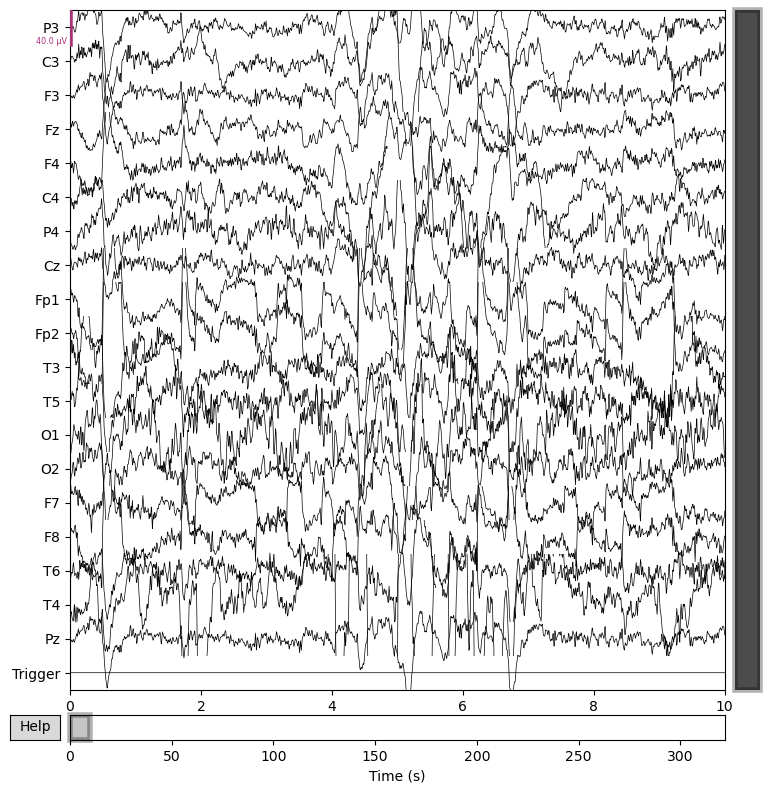

In [5]:
# Step 3: Filtering
# Extract filtering parameters from the configuration
filter_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'FilterStep')

# Use the FilterStep from the pipeline
from scr.steps.filter import FilterStep

# Create and apply the filter step
logger.info(f"Applying filtering using FilterStep")
filter_step = FilterStep(params=filter_config['params'])
raw = filter_step.run(raw)

# Plot power spectral density after filtering
fig, ax = plt.subplots(figsize=(10, 6))
raw.compute_psd(fmax=filter_config['params']['h_freq']*1.5, picks='eeg').plot(show=True)
ax.set_title('Power Spectral Density after Filtering')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB)')
plt.show()

# Plot filtered data
raw.plot(duration=10, n_channels=20, title='Filtered EEG data')

## Advanced Spectral Analysis

Let's use the spectral analysis utilities to visualize the data in different ways.

In [6]:
# Example of using the spectral analysis utilities
from scr.utils.spectral import compute_and_plot_psd

# Plot standard PSD
logger.info("Plotting standard PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='standard')
except Exception as e:
    logger.error(f"Error plotting standard PSD: {str(e)}")

# Plot average PSD across channels
logger.info("Plotting average PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='average',
                        plot_kwargs={'color': 'blue', 'linewidth': 2})
except Exception as e:
    logger.error(f"Error plotting average PSD: {str(e)}")

# Plot PSD by frequency bands
logger.info("Plotting PSD by frequency bands")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=45,
                        picks='eeg',
                        plot_type='bands',
                        plot_kwargs={'bands': {
                            'delta': (1, 4),
                            'theta': (4, 8),
                            'alpha': (8, 13),
                            'beta': (13, 30),
                            'gamma': (30, 45)
                        }})
except Exception as e:
    logger.error(f"Error plotting PSD by frequency bands: {str(e)}")

2025-08-26 16:04:45,242 - fivepoint_pipeline - INFO - Plotting standard PSD
2025-08-26 16:04:45,243 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-08-26 16:04:45,288 - root - INFO - PSD shape: (19, 406), Freqs shape: (406,)


Plotting power spectral density (dB=True).


e:\Yann\neurotheque_resources\scr\utils\spectral.py:265: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
e:\Yann\neurotheque_resources\scr\utils\spectral.py:265: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-08-26 16:04:45,654 - fivepoint_pipeline - INFO - Plotting average PSD
2025-08-26 16:04:45,656 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-08-26 16:04:45,700 - root - INFO - PSD shape: (19, 406), Freqs shape: (406,)
2025-08-26 16:04:45,937 - fivepoint_pipeline - INFO - Plotting PSD by frequency bands
2025-08-26 16:04:45,939 - root - INFO - Computing PSD using welch method


Effective window size : 6.827 (s)


2025-08-26 16:04:45,985 - root - INFO - PSD shape: (19, 304), Freqs shape: (304,)


## Step 4: Epoching for Autoreject

For the five-point test, we'll create fixed-length epochs of 2 seconds duration without any baseline correction. This approach creates uniform time segments that are ideal for the autoreject algorithm, which can then identify and handle artifacts in a consistent way across the entire recording.

Instead of event-locked epochs, we're creating regular fixed-length segments (2 seconds each) throughout the recording. This method:
- Provides consistent coverage of the entire recording
- Creates uniform segments for artifact detection
- Works well when specific event markers aren't needed for analysis
- Is particularly effective for autoreject processing

In [7]:
# Step 4: Epoching
# Extract epoching parameters from the configuration
epoch_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'EpochingStep')

# Make sure required parameters are set
if 'params' not in epoch_config:
    epoch_config['params'] = {}

# Set critical parameters for fixed-length epochs for five-point task
epoch_config['params']['task_type'] = 'fixed'  # Use fixed-length epochs
epoch_config['params']['stim_channel'] = 'Trigger'  # Make sure stim channel is set

# Configure fixed-length epoch parameters
epoch_config['params']['epoch_params'] = {
    'duration': 4.0,      # 2-second epochs
    'overlap': 0.0,       # No overlap between segments
    'baseline': None,     # No baseline correction
    'preload': True,
    'reject_by_annotation': True
}

# Configure the event visualization
epoch_config['params']['visualize_events'] = True
epoch_config['params']['plot_params'] = {
    # Event visualization parameters
    'duration': 15.0,
    'tstart': 0.0,
    'interactive': True,
    'save_plots': True,
    'save_dir': os.path.join(processed_dir, 'figures/events')
}

# Log important parameters for reference
duration = epoch_config['params']['epoch_params']['duration']
overlap = epoch_config['params']['epoch_params']['overlap']
baseline = epoch_config['params']['epoch_params']['baseline']
stim_channel = epoch_config['params']['stim_channel']

print("\nFixed-length epoch parameters:")
print(f"- Duration: {duration}s")
print(f"- Overlap: {overlap}s")
print(f"- Baseline: {baseline}")

# Create and run the epoching step
from scr.steps.epoching import EpochingStep
logger.info(f"Creating fixed-length epochs of {duration}s duration with task_type={epoch_config['params']['task_type']}")
epoch_step = EpochingStep(params=epoch_config['params'])

# Run the epoching step
try:
    epochs = epoch_step.run(raw)

    # Display information about the epochs
    print("\nEpochs information:")
    print(epochs)

    # Use the generate_plots method with butterfly plot type (should work well)
    try:
        butterfly_plot = epoch_step.generate_plots(
            epochs,
            plot_params={
                'plot_type': 'butterfly',
                'event_names': ['fixed'],
                'channels': ['Fz', 'Cz', 'Pz'],
                'time_window': [0, 2.0],
                'save_plots': True,
                'save_dir': os.path.join(processed_dir, 'figures/epochs')
            }
        )
        print("Successfully generated butterfly plot")
    except Exception as e:
        print(f"Error generating butterfly plot: {str(e)}")
    
    # Try the average plot type with minimal parameters
    try:
        average_plot = epoch_step.generate_plots(
            epochs,
            plot_params={
                'plot_type': 'average',
                'event_names': ['fixed'],
                'channels': ['Fz', 'Cz', 'Pz'],
                # Avoid passing title which may cause issues
                'save_plots': True,
                'save_dir': os.path.join(processed_dir, 'figures/epochs')
            }
        )
        print("Successfully generated average plot")
    except Exception as e:
        print(f"Error generating average plot: {str(e)}")
    
    # Use direct MNE plotting methods as a fallback
    print("\nUsing MNE's native plotting methods...")
    
    # Plot a few channels from a few epochs
    fig1 = epochs.plot(picks=['Fz', 'Cz', 'Pz'], n_epochs=5, 
                      scalings='auto', 
                      title='Fixed-length 2s epochs')
    
    # Plot the average across all fixed epochs
    evoked = epochs.average()
    fig2 = evoked.plot(picks=['Fz', 'Cz', 'Pz'], 
                      titles='Average of fixed-length epochs')
    
    # Use the newer PSD method to avoid deprecation warnings
    fig3 = epochs.compute_psd().plot(picks=['Fz', 'Cz', 'Pz'], 
                                   average=True)
    
    # Save the figures
    save_dir = os.path.join(processed_dir, 'figures/epochs')
    os.makedirs(save_dir, exist_ok=True)
    
    fig1.savefig(os.path.join(save_dir, 'fixed_epochs_raw.png'))
    fig2.savefig(os.path.join(save_dir, 'fixed_epochs_average.png'))
    fig3.savefig(os.path.join(save_dir, 'fixed_epochs_psd.png'))
    
except Exception as e:
    logger.error(f"Error in epoching step: {str(e)}")

2025-08-26 16:04:46,927 - fivepoint_pipeline - INFO - Creating fixed-length epochs of 4.0s duration with task_type=fixed
2025-08-26 16:04:46,928 - root - INFO - [EpochingStep.__init__] Initialized with params: {'task_type': 'fixed', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'duration': 4.0, 'overlap': 0.0, 'baseline': None, 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_params': {'duration': 15.0, 'tstart': 0.0, 'interactive': True, 'save_plots': True, 'save_dir': 'e:/Yann/neurotheque_resources/data/processed\\figures/events'}}
2025-08-26 16:04:46,929 - root - INFO - [EpochingStep.run] Running with params: {'task_type': 'fixed', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'duration': 4.0, 'overlap': 0.0, 'baseline': None, 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_p


Fixed-length epoch parameters:
- Duration: 4.0s
- Overlap: 0.0s
- Baseline: None
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1201 original time points ...
0 bad epochs dropped


2025-08-26 16:04:46,963 - root - INFO - [EpochingStep] Created 80 fixed-length epochs


Adding metadata with 0 columns

Epochs information:
<Epochs | 80 events (all good), 0 – 4 s (baseline off), ~14.7 MiB, data loaded, with metadata,
 'fixed': 80>


e:\Yann\neurotheque_resources\scr\steps\epoching.py:995: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-08-26 16:04:47,570 - root - INFO - [EpochingStep] Saved figure to e:\Yann\neurotheque_resources\data\processed\figures\epochs\sub-unknown_ses-001_plot-1.png


Successfully generated butterfly plot


e:\Yann\neurotheque_resources\scr\steps\epoching.py:977: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
e:\Yann\neurotheque_resources\scr\steps\epoching.py:977: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-08-26 16:04:48,255 - root - INFO - [EpochingStep] Saved figure to e:\Yann\neurotheque_resources\data\processed\figures\epochs\sub-unknown_ses-001_plot-1.png


Successfully generated average plot

Using MNE's native plotting methods...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


In [8]:
# Define output file path and save epochs

# Get save checkpoint step configuration from pipeline config
save_checkpoint_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'SaveCheckpoint')

# Import the SaveCheckpoint class from the pipeline steps
from scr.steps.save_checkpoint import SaveCheckpoint

# Create paths object from config if not already available
from scr.steps.project_paths import ProjectPaths
paths = ProjectPaths(config)

# Prepare parameters for SaveCheckpoint
save_params = save_checkpoint_config.get('params', {}).copy()

# Add required parameters
save_params.update({
    "subject_id": config.get('default_subject', '01'),
    "session_id": config.get('default_session', '001'),
    "task_id": "gng",
    "run_id": config.get('default_run', '01'),
    "checkpoint_key": "epoched",  # Customize the checkpoint name
    "paths": paths,
    "overwrite": True
})

# Create and run the SaveCheckpoint step
save_step = SaveCheckpoint(params=save_params)
save_step.run(epochs)

# Get the path for informational message
checkpoint_path = paths.get_checkpoint_path(
    subject_id=save_params["subject_id"],
    session_id=save_params["session_id"],
    task_id=save_params["task_id"],
    run_id=save_params["run_id"],
    checkpoint_name=save_params["checkpoint_key"]
)

print(f"\nPreprocessed epochs saved as checkpoint: {checkpoint_path}")



2025-08-26 16:04:52,456 - root - INFO - Saving checkpoint to: E:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif


Overwriting existing file.
Overwriting existing file.


e:\Yann\neurotheque_resources\scr\steps\save_checkpoint.py:26: RuntimeWarning: This filename (E:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data.save(ckpt_path, overwrite=True)



Preprocessed epochs saved as checkpoint: E:\Yann\neurotheque_resources\data\processed\sub-01\ses-001\sub-01_ses-001_task-gng_run-01_epoched.fif


# Step 5: First AutoReject Pass
We now apply AutoReject to identify bad epochs from our fixed-length segments. AutoReject uses a machine learning approach to automatically detect and reject or repair problematic epochs, ensuring high data quality without subjective manual rejection.

In [9]:
# Step 5: Apply AutoReject to identify bad epochs
from scr.steps.autoreject import AutoRejectStep

# Configure AutoReject parameters
ar_params_dict = {
    "n_interpolate": None,  # Use default values
    "consensus": None,      # Use default values
    "thresh_method": "bayesian_optimization",
    "n_jobs": 1,
}

# Set up the AutoReject step parameters
autoreject_dir = os.path.join(processed_dir, "autoreject")
os.makedirs(autoreject_dir, exist_ok=True)

autoreject_params = {
    "ar_params": ar_params_dict,
    "plot_results": True,  
    "interactive": True,   
    "mode": "fit",                  # Only identify bad epochs, don't clean yet
    "file_prefix": "ar_first_pass",
    "output_dir": os.path.join(processed_dir, "autoreject"),
    "plot_dir": autoreject_dir,     
    "store_reject_log": True,
    "save_model": False,            
    "subject_id": config.get('default_subject', '01'),
    "session_id": config.get('default_session', '001'),
    "run_id": config.get('default_run', '01'),
    "save_cleaned_data": False,     
}

# Create and run the AutoReject step
logger.info("Applying AutoReject to identify bad epochs")
autoreject_step = AutoRejectStep(params=autoreject_params)
print(f"Data shape before AutoReject: {epochs.get_data().shape} (epochs x channels x time points)")
epochs_with_ar = autoreject_step.run(epochs)

# Display results
if hasattr(epochs_with_ar, 'metadata') and 'ar_reject_log' in epochs_with_ar.metadata:
    reject_log = epochs_with_ar.metadata['ar_reject_log']
    n_bad_epochs = reject_log.bad_epochs.sum()
    percent_bad = (n_bad_epochs / len(epochs)) * 100
    print(f"\nAutoReject identified {n_bad_epochs} bad epochs ({percent_bad:.1f}% of total)")

2025-08-26 16:04:52,983 - fivepoint_pipeline - INFO - Applying AutoReject to identify bad epochs
2025-08-26 16:04:52,987 - root - INFO - [AutoRejectStep] Data type: <class 'mne.epochs.Epochs'>


Data shape before AutoReject: (80, 20, 1201) (epochs x channels x time points)


2025-08-26 16:04:52,989 - root - INFO - [AutoRejectStep] Is instance of mne.Epochs: True
2025-08-26 16:04:52,990 - root - INFO - [AutoRejectStep] Switching matplotlib backend from tkagg to TkAgg for interactive plotting
2025-08-26 16:04:52,992 - root - INFO - [AutoRejectStep] Using existing epochs for AutoReject.
2025-08-26 16:04:52,992 - root - INFO - [AutoRejectStep] Running AutoReject with params: {'n_interpolate': None, 'consensus': None, 'thresh_method': 'bayesian_optimization', 'n_jobs': 1}


Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/80 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/80 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/80 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/80 [00:00<?,       ?it/s]

c:\Users\snesm\anaconda3\envs\neuropipe\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\snesm\anaconda3\envs\neuropipe\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\snesm\anaconda3\envs\neuropipe\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\snesm\anaconda3\envs\neuropipe\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


2025-08-26 16:05:27,160 - root - INFO - [AutoRejectStep] Running in 'fit' mode - only identifying bad epochs
2025-08-26 16:05:27,165 - root - INFO - [AutoRejectStep] Data already in epochs format. Bad epochs stored in data.info['temp']['autoreject_bad_epochs']
2025-08-26 16:05:27,165 - root - INFO - [AutoRejectStep] Found 10 bad epochs out of 80
2025-08-26 16:05:27,166 - root - INFO - [AutoRejectStep] AutoReject identified 10 bad epochs out of 80 (12.5%)
2025-08-26 16:05:27,799 - root - WARNING - [AutoRejectStep] Error creating thresholds visualization: 0
2025-08-26 16:05:27,801 - root - INFO - [AutoRejectStep] Excluding trigger/stim channels from rejection plot: ['Trigger']
2025-08-26 16:05:28,408 - root - INFO - [AutoRejectStep] Saved channel rejection rates visualization to e:/Yann/neurotheque_resources/data/processed\autoreject
2025-08-26 16:05:28,409 - root - INFO - [AutoRejectStep] Stored AutoReject information in data.info['temp']
2025-08-26 16:05:28,410 - root - INFO - [AutoRej

## Step 6: ICA Extraction

Now we'll run Independent Component Analysis (ICA) on the good epochs identified by AutoReject.

2025-08-26 16:05:29,104 - fivepoint_pipeline - INFO - Running ICA extraction for task: 5pt
2025-08-26 16:05:29,251 - root - INFO - [ICAExtractionStep] Jupyter environment detected, using inline backend
2025-08-26 16:05:29,253 - root - INFO - [ICAExtractionStep] Using data with AutoReject annotations to exclude bad segments.
2025-08-26 16:05:29,254 - root - INFO - [ICAExtractionStep] Input is already epoched data
2025-08-26 16:05:29,254 - root - INFO - [ICAExtractionStep] Found 10 bad epochs from autoreject_bad_epochs
2025-08-26 16:05:29,266 - root - INFO - [ICAExtractionStep] Using 70/80 good epochs for ICA
2025-08-26 16:05:29,268 - root - INFO - [ICAExtractionStep] Saving plots to e:/Yann/neurotheque_resources/data/processed\ica
2025-08-26 16:05:29,269 - root - INFO - [ICAExtractionStep] Fitting ICA with 18 components using infomax method...


Data shape before ICA extraction: (80, 20, 1201)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 18 components
Computing Extended Infomax ICA
Fitting ICA took 21.3s.


2025-08-26 16:05:50,605 - root - INFO - [ICAExtractionStep] ICA fitted successfully. Found 18 components.
2025-08-26 16:05:50,606 - root - INFO - [ICAExtractionStep] Generating component topography plots


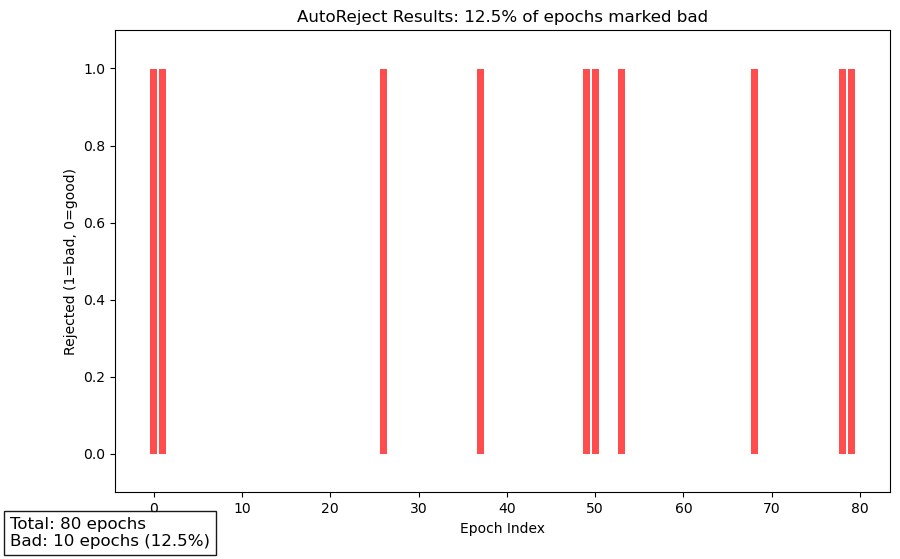

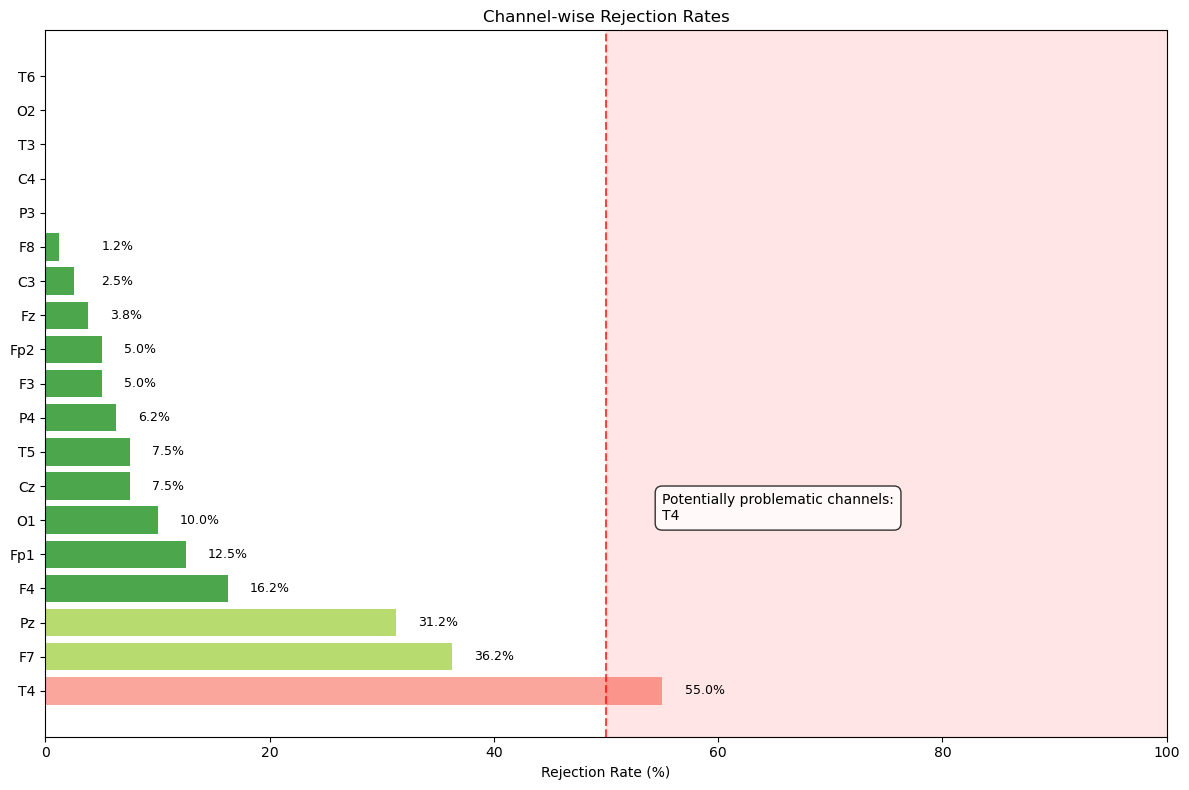

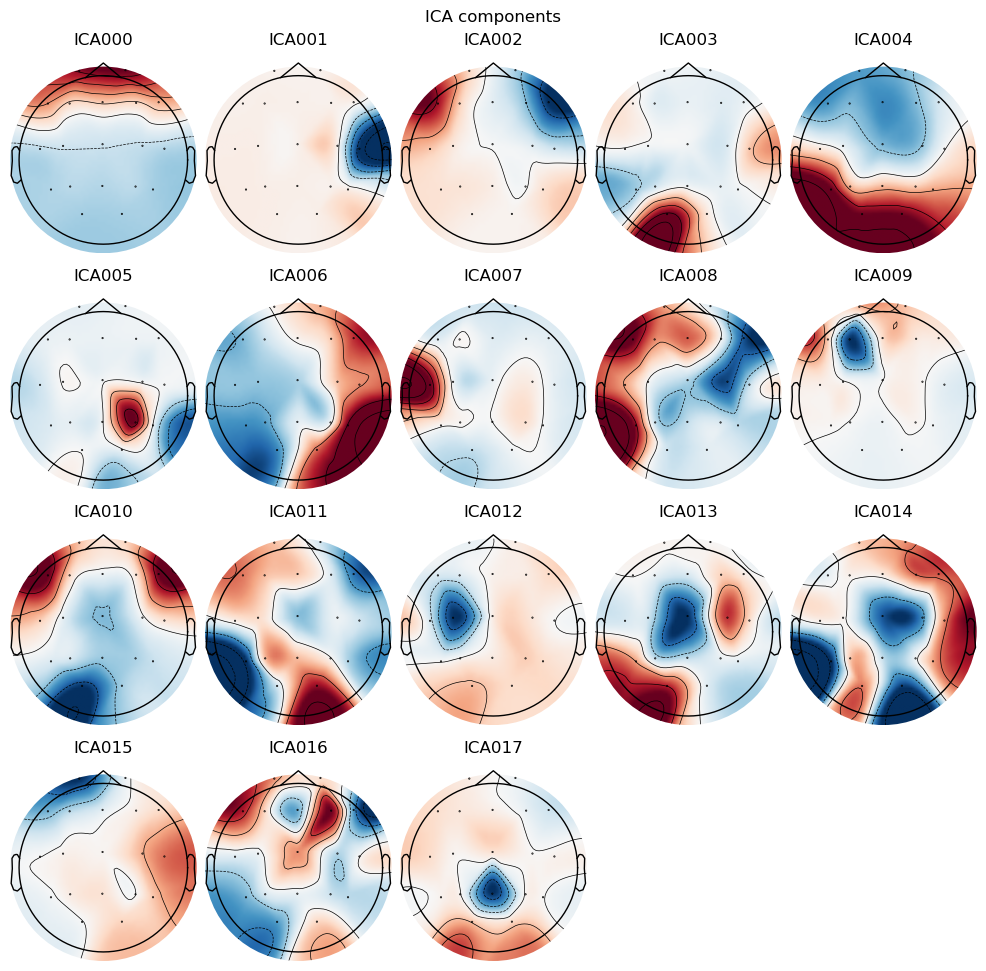


Displaying 1 generated ICA figures...

ICA extraction complete.


In [10]:
# Step 6: Run ICA extraction on the AutoReject results
from scr.steps.ica_extraction import ICAExtractionStep
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Define directory for ICA plots
ica_extraction_dir = os.path.join(processed_dir, "ica")
os.makedirs(ica_extraction_dir, exist_ok=True)

# Configure ICA parameters
ica_params = {
    "n_components": 18,  # Adjust based on number of channels and desired variance explained
    "method": "infomax",   # Suitable for EEG
    "max_iter": 2000,      # Increase iterations for potentially better convergence
    "fit_params": {"extended": True},  # Extended Infomax for diverse source types
    "decim": None             # No temporal decimation
}

# Retrieve subject/session/run/task IDs (ensure these are defined earlier)
sub_id = config.get('default_subject', '01')
ses_id = config.get('default_session', '001')
run_id = config.get('default_run', '01')
task_id = '5pt' # Set task ID specifically for the five-point task

# Set up the ICA extraction step parameters
ica_extraction_params = {
    "n_components": ica_params["n_components"],
    "method": ica_params["method"],
    "max_iter": ica_params["max_iter"],
    "fit_params": ica_params["fit_params"],
    "decim": ica_params["decim"],
    "use_good_epochs_only": True,  # Use only good epochs identified by AutoReject
    "plot_dir": ica_extraction_dir,
    "plot_components": True,       # Plot the component topographies
    "plot_sources": False,          # Plot the time course of components
    "plot_properties": False,       # Plot detailed properties (spectrum, variance, etc.)
    "plot_psd": False,              # Plot PSD of components
    "interactive": False,          # Set to False for notebook display
    "subject_id": sub_id,
    "session_id": ses_id,
    "run_id": run_id,
    "task_id": task_id,            # Use the correct task ID
    "save_data": False,            # Don't save checkpoint here
    "store_ica_in_epochs": True   # Store ICA object in epochs.info['temp']                # Pass the ProjectPaths object
}

# Create and run the ICA extraction step
logger.info(f"Running ICA extraction for task: {task_id}")
ica_extraction_step = ICAExtractionStep(params=ica_extraction_params)

# Ensure the input is the epochs object from the previous AutoReject step
if 'epochs_with_ar' in locals() and epochs_with_ar is not None:
    print(f"Data shape before ICA extraction: {epochs_with_ar.get_data().shape}")
    try:
        # The run method will use the 'autoreject_bad_epochs' stored in info['temp']
        epochs_with_ica = ica_extraction_step.run(epochs_with_ar)
        
        # Display ICA figures manually since interactive=False
        if hasattr(ica_extraction_step, 'figures') and ica_extraction_step.figures:
            print(f"\nDisplaying {len(ica_extraction_step.figures)} generated ICA figures...")
            for fig in ica_extraction_step.figures:
                # Check if the figure still exists (might have been closed)
                if plt.fignum_exists(fig.number):
                    plt.figure(fig.number) # Bring figure to front
                    plt.show() # Display the figure
        
        print("\nICA extraction complete.")
        
    except Exception as e:
        logger.error(f"Error during ICA extraction: {str(e)}")
else:
    logger.error("Input epochs object 'epochs_with_ar' not found or is None.")


## Step 7: ICA Labeling and Artifact Removal

In this step, we'll identify and remove ICA components related to artifacts (eye movements, muscle activity, heartbeat).

Saving exclusion plots to: e:/Yann/neurotheque_resources/data/processed\ica_exclusion_plots

--- Running ICLabel Classification ---


C:\Users\snesm\AppData\Roaming\Python\Python311\site-packages\mne_icalabel\iclabel\features.py:67: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  warn(


ICLabel classifications:
IC0: eye blink (97.7%)
IC1: other (48.2%)
IC2: eye blink (99.3%)
IC3: other (54.9%)
IC4: brain (97.4%)
IC5: brain (76.7%)
IC6: brain (82.8%)
IC7: other (61.1%)
IC8: brain (56.3%)
IC9: other (44.6%)
IC10: other (56.7%)
IC11: other (61.5%)
IC12: brain (95.9%)
IC13: brain (56.7%)
IC14: other (73.9%)
IC15: eye blink (82.5%)
IC16: other (92.3%)
IC17: brain (87.0%)

Components to exclude: [0, 2, 15]
Exclusion by artifact type:
  eye blink: [0, 2, 15]
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events f

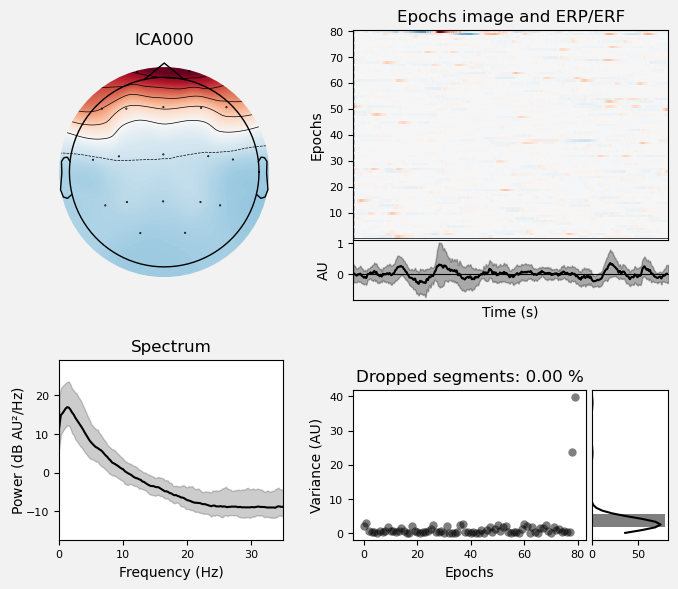

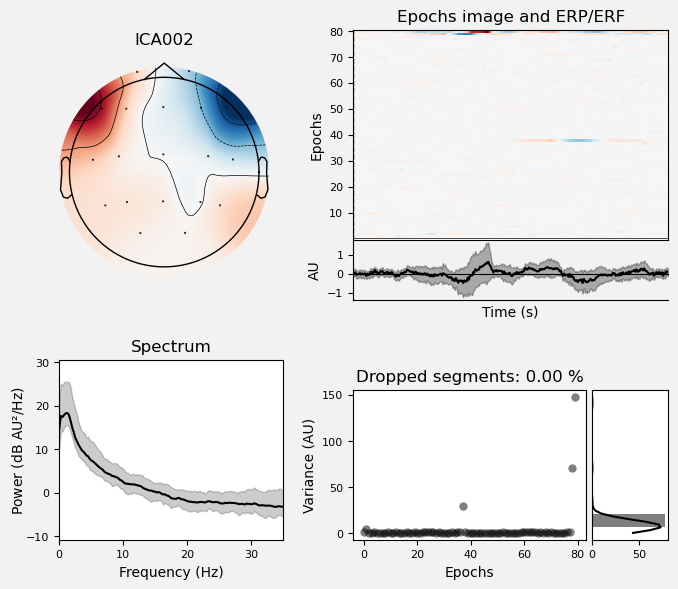

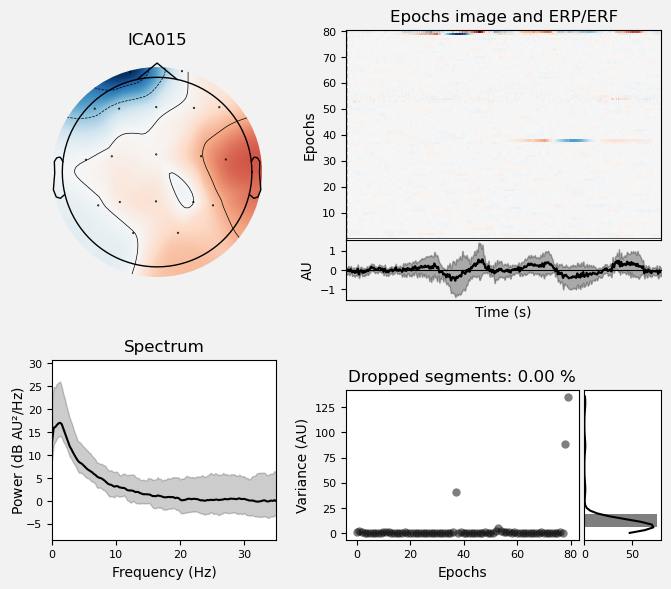

Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components

--- Applying ICA exclusion to create clean dataset ---
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Error during I

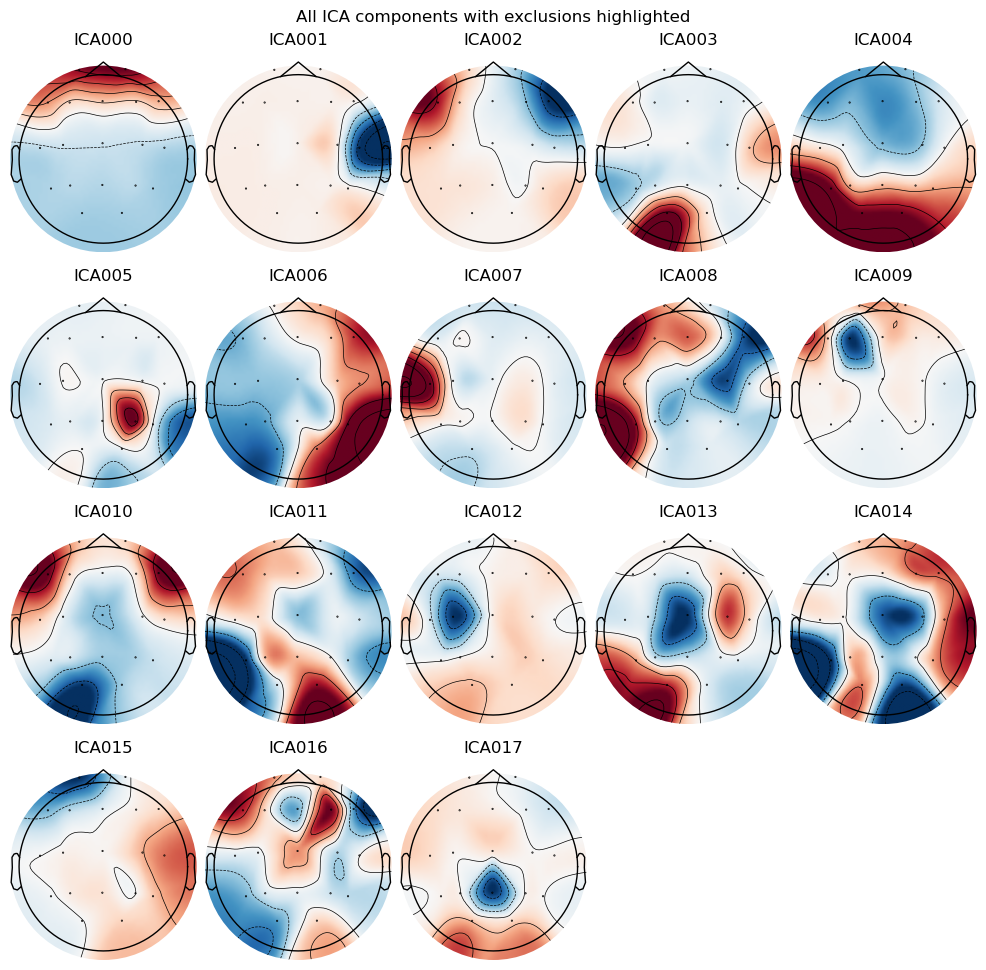


Additional plots created to clearly show excluded components


In [11]:
# Step 8: Using ICLabel to identify and exclude artifact components

import mne
import matplotlib.pyplot as plt
import numpy as np
import os
from mne.preprocessing import ICA
from mne_icalabel import label_components

# Ensure plots are displayed inline
%matplotlib inline



# Get the ICA solution
ica = epochs_with_ica.info['temp']['ica']
epochs_for_cleaning = epochs_with_ica.copy()  # Work on a copy

# --- Plotting Directory ---
ica_clean_dir = os.path.join(processed_dir, "ica_exclusion_plots")
os.makedirs(ica_clean_dir, exist_ok=True)
print(f"Saving exclusion plots to: {ica_clean_dir}")

# --- ICLabel Classification ---
print("\n--- Running ICLabel Classification ---")
ic_labels = {}

try:
    # Apply ICLabel classification
    ic_labels = label_components(epochs_for_cleaning, ica, method='iclabel')
    labels = ic_labels["labels"]
    probs = ic_labels["y_pred_proba"]
    
    print("ICLabel classifications:")
    for i, (label, prob) in enumerate(zip(labels, probs)):
        print(f"IC{i}: {label} ({prob*100:.1f}%)")
    
    # Define artifact types to exclude
    artifact_types = ['eye blink', 'heart', 'line_noise', 'channel_noise']
    
    # Set probability thresholds (adjust as needed)
    thresholds = {
        'eye blink': 0.7,         # Eye movement/blink artifacts
        'heart': 0.6,       # Cardiac artifacts
        'line_noise': 0.6,  # Power line noise (50/60Hz)
        'channel_noise': 0.6 # Single channel noise
    }
    
    # Select components to exclude based on artifact types and thresholds
    exclude_indices = []
    for i, (label, prob) in enumerate(zip(labels, probs)):
        if label in artifact_types and prob >= thresholds.get(label, 0.6):
            exclude_indices.append(i)
    
    # Sort exclude indices for cleaner output
    exclude_indices.sort()
    
    print(f"\nComponents to exclude: {exclude_indices}")
    print("Exclusion by artifact type:")
    for artifact in artifact_types:
        artifact_indices = [i for i, (label, prob) in enumerate(zip(labels, probs)) 
                          if label == artifact and prob >= thresholds.get(artifact, 0.6)]
        if artifact_indices:
            print(f"  {artifact}: {artifact_indices}")
    
    # --- Plotting and Exclusion ---
    # Plot properties of components to be excluded
    if exclude_indices:
        # Plot component properties
        fig_props = ica.plot_properties(epochs_for_cleaning, picks=exclude_indices, psd_args={'fmax': 35.})
        
        # Save component property plots
        for i, fig in enumerate(fig_props):
            comp_idx = exclude_indices[i]
            label_str = f"IC {comp_idx}: {labels[comp_idx]} ({probs[comp_idx]*100:.1f}%)"
            fig.suptitle(label_str, y=0.98)
            fig.savefig(os.path.join(ica_clean_dir, f"excluded_comp{comp_idx}.png"))
        plt.close('all')
        
        # Plot overlay of raw data before and after exclusion
        # Select 5 example epochs for demonstration
        example_epochs = min(5, len(epochs_for_cleaning))
        for epoch_idx in range(example_epochs):
            # Plot before exclusion
            fig_before = epochs_for_cleaning[epoch_idx].plot(show=False, title=f"Epoch {epoch_idx} - Before ICA cleaning")
            fig_before.savefig(os.path.join(ica_clean_dir, f"epoch{epoch_idx}_before.png"))
            plt.close(fig_before)
            
            # Apply ICA exclusion for comparison
            epochs_cleaned = epochs_for_cleaning.copy()
            ica.apply(epochs_cleaned, exclude=exclude_indices)
            
            # Plot after exclusion
            fig_after = epochs_cleaned[epoch_idx].plot(show=False, title=f"Epoch {epoch_idx} - After ICA cleaning")
            fig_after.savefig(os.path.join(ica_clean_dir, f"epoch{epoch_idx}_after.png"))
            plt.close(fig_after)
        
        # Apply ICA with exclusion to create clean dataset
        print("\n--- Applying ICA exclusion to create clean dataset ---")
        ica.apply(epochs_for_cleaning, exclude=exclude_indices)
        
        # Store excluded components in epochs info
        if 'excluded_ica_indices' not in epochs_for_cleaning.info:
            epochs_for_cleaning.info['excluded_ica_indices'] = exclude_indices
        
        # Create a plot showing power spectrum before and after
        fig_psd, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        epochs_with_ica.plot_psd(ax=axes[0], fmax=80, show=False)
        axes[0].set_title('Before ICA cleaning')
        epochs_for_cleaning.plot_psd(ax=axes[1], fmax=80, show=False)
        axes[1].set_title('After ICA cleaning')
        fig_psd.tight_layout()
        fig_psd.savefig(os.path.join(ica_clean_dir, "psd_comparison.png"))
        plt.close(fig_psd)
        
        print(f"\nExcluded {len(exclude_indices)} components: {exclude_indices}")
        print(f"Clean epochs saved in 'epochs_cleaned'")
        
        # Store cleaned epochs
        epochs_cleaned = epochs_for_cleaning
    else:
        print("No components selected for exclusion based on current thresholds.")
        epochs_cleaned = epochs_for_cleaning

except ImportError:
    print("mne_icalabel is not installed. Please install it using: pip install mne-icalabel")
    epochs_cleaned = epochs_for_cleaning
except Exception as e:
    print(f"Error during ICLabel cleaning: {e}")
    epochs_cleaned = epochs_for_cleaning

# --- Final Summary ---
print("\n--- ICLabel Cleaning Summary ---")
print(f"Identified artifact components: {exclude_indices}")
print(f"Review the plots in: {ica_clean_dir}")
print("Proceed to the next preprocessing step with 'epochs_cleaned'")

# Plot interactive view of all components for final review
fig_components = ica.plot_components(title="All ICA components with exclusions highlighted")

# Highlight excluded components in red
if exclude_indices:
    # Get the axes - handling both flattened and nested arrays
    if hasattr(fig_components, 'axes'):
        # Check if axes is a flat list or a nested list
        if hasattr(fig_components.axes, 'flat'):
            # It's a 2D array/grid of axes, flatten it
            axes_list = list(fig_components.axes.flat)
        elif isinstance(fig_components.axes, list):
            # It might already be a flat list
            if len(fig_components.axes) > 0 and hasattr(fig_components.axes[0], '__iter__'):
                # Nested list, flatten it
                axes_list = [ax for sublist in fig_components.axes for ax in sublist]
            else:
                # Already a flat list
                axes_list = fig_components.axes
        else:
            # Single axes object
            axes_list = [fig_components.axes]
            
        # Now highlight excluded components
        for idx in exclude_indices:
            if idx < len(axes_list):
                ax = axes_list[idx]
                # Add a red border
                ax.patch.set_edgecolor('red')
                ax.patch.set_linewidth(3.0)
                
                # Add a text label indicating this is excluded
                ax.text(0.5, 0.1, 'EXCLUDED', 
                       horizontalalignment='center',
                       color='red', 
                       fontweight='bold',
                       fontsize=12,
                       transform=ax.transAxes,
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

    # Add a title to make it clear
    fig_components.suptitle("ICA Components (Red Border = Excluded)", fontsize=16, color='black', y=0.99)
    
    # Save the figure
    fig_components.savefig(os.path.join(ica_clean_dir, "all_components_with_exclusions.png"))

plt.close(fig_components)

# Create an additional summary plot that's more visually clear about exclusions
n_excluded = len(exclude_indices)
if n_excluded > 0:
    fig_summary, axes = plt.subplots(1, n_excluded, figsize=(4*n_excluded, 4))
    
    # Make axes iterable even if there's only one
    if n_excluded == 1:
        axes = [axes]
    
    for i, idx in enumerate(exclude_indices):
        # Plot component topography on a fresh figure to avoid conflicts
        temp_fig = ica.plot_components(picks=idx, show=False)
        plt.close(temp_fig)  # Close the temporary figure
        
        # Now plot again on our summary figure
        ica.plot_components(picks=idx, axes=axes[i], colorbar=False, show=False)
        
        # Add component info as title
        label = labels[idx] if 'labels' in locals() else "Unknown"
        prob = probs[idx]*100 if 'probs' in locals() else 0
        axes[i].set_title(f"IC{idx}: {label}\n({prob:.1f}%)", color='red', fontweight='bold')
    
    plt.tight_layout()
    fig_summary.savefig(os.path.join(ica_clean_dir, "excluded_components_summary.png"))
    plt.close(fig_summary)
    
    print("\nAdditional plots created to clearly show excluded components")
else:
    print("\nNo components were excluded, so no summary plot was created")

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

# — Make sure these exist in your namespace:
#    ica             : your fitted ICA instance
#    raw             : your Raw or Epochs object
#    exclude_indices : list of component indices to exclude
#    labels (opt)    : ICLabel names array, same length as n_components
#    probs (opt)     : ICLabel probabilities array, same length as n_components
#    ica_clean_dir   : directory where you want to save the figure

# 1) Get the unmixing weights and channel info
weights = ica.get_components()      # shape: (n_channels, n_components)
info    = raw.info                  # or epochs.info

n_comp = weights.shape[1]
ncols  = 8                          # adjust columns to your screen/paper
nrows  = int(np.ceil(n_comp / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(2.5 * ncols, 2.5 * nrows),
    squeeze=False
)

# 2) Compute a global limit for a symmetrical color scale
vlim = np.max(np.abs(weights)) * 0.8

# 3) Loop through and plot each component
for comp_idx, ax in enumerate(axes.flat):
    if comp_idx >= n_comp:
        ax.axis('off')
        continue

    # draw the topomap with valid 'cubic' interpolation
    im, _ = plot_topomap(
        weights[:, comp_idx], info,
        axes=ax, show=False,
        cmap='RdBu_r',           # diverging map
        sensors=True,            # plot electrode dots
        outlines='head',         # supported outline option
        contours=6,              # nice contour lines
        image_interp='cubic'     # first-pass interpolation
    )
    # enforce symmetric scaling
    im.set_clim(-vlim, vlim)
    # apply matplotlib's bilinear smoothing if you like
    im.set_interpolation('bilinear')

    # title each subplot
    ax.set_title(f"IC{comp_idx:03d}", fontsize=10, pad=2)

    # highlight exclusions
    if comp_idx in exclude_indices:
        ax.patch.set_edgecolor('red')
        ax.patch.set_linewidth(3.0)

        # optional ICLabel text
        label = labels[comp_idx] if 'labels' in locals() else "Excluded"
        prob  = probs[comp_idx] * 100 if 'probs' in locals() else None
        ann   = f"{label}\n{prob:.1f} %" if prob is not None else label

        ax.text(
            0.5, 0.1, ann,
            transform=ax.transAxes,
            ha='center', va='bottom',
            color='red', fontsize=8, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round')
        )

# 4) Remove ticks & spines for a clean look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# 5) Add a single horizontal colorbar
cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.03])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title('Component amplitude (a.u.)', fontsize=10)

# 6) Super‑title, layout, save, and close
fig.suptitle(
    "ICA Components\n(red border & label = excluded)",
    fontsize=16, y=0.96
)
fig.tight_layout(rect=[0, 0.05, 1, 0.93])

os.makedirs(ica_clean_dir, exist_ok=True)
out_path = os.path.join(ica_clean_dir, "all_components_pub_ready.png")
fig.savefig(out_path, dpi=300)
plt.close(fig)

print(f"Saved publication‑ready ICA grid to:\n  {out_path}")


C:\Users\snesm\AppData\Local\Temp\ipykernel_3488\2509313365.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.93])


Saved publication‑ready ICA grid to:
  e:/Yann/neurotheque_resources/data/processed\ica_exclusion_plots\all_components_pub_ready.png


🧹 Excluding ICA components: [0, 2, 15]
📂 Saving plots to: e:/Yann/neurotheque_resources/data/processed\ica_reconstruction_plots
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
✅ ICA applied—`epochs_clean` created.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\snesm\AppData\Local\Temp\ipykernel_3488\735117376.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


🎯 ERP comparison saved.
⚠️ Skipping topographic map: You must provide 4 axes (one for each time plus one for the colorbar), got 3.
Saved publication‑ready ICA grid to:
  e:/Yann/neurotheque_resources/data/processed\ica_reconstruction_plots\all_components_pub_ready.png

🔔 ICA Reconstruction complete.
  • Clean epochs: `epochs_clean`
  • All plots in: e:/Yann/neurotheque_resources/data/processed\ica_reconstruction_plots
  • Excluded ICA components: [0, 2, 15] (stored in epochs_clean.info['temp']['excluded_ica_indices'])


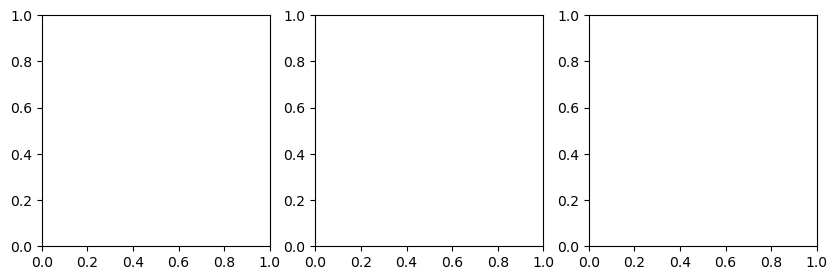

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
# Instead of importing psd_welch directly, we'll use epochs.compute_psd()

# --- Inputs & Config ---
# ica: fitted ICA instance
# exclude_indices: list of IC indices (e.g., [1,2])
# epochs_with_ica: pre‑ICA Epochs (with preload=True)
# processed_dir: base directory for outputs

# 0) Sanity checks
if not hasattr(ica, 'apply'):
    raise RuntimeError("ICA instance missing—run ICA extraction first.")
if not hasattr(epochs_with_ica, 'get_data'):
    raise RuntimeError("Provide `epochs_with_ica` with preload=True.")
exclude_indices = locals().get('exclude_indices', [])
print(f"🧹 Excluding ICA components: {exclude_indices}")

# 1) Prepare output directory
out_dir = os.path.join(processed_dir, "ica_reconstruction_plots")
os.makedirs(out_dir, exist_ok=True)
print(f"📂 Saving plots to: {out_dir}")

# 2) Apply ICA on a copy to reconstruct cleaned epochs
epochs_clean = epochs_with_ica.copy()
ica.apply(epochs_clean, exclude=exclude_indices)
print("✅ ICA applied—`epochs_clean` created.")

# 3) Time‑series comparison (manual plotting)
channel = 'Cz' if 'Cz' in epochs_with_ica.ch_names else epochs_with_ica.ch_names[0]
ch_idx = epochs_with_ica.ch_names.index(channel)
times = epochs_with_ica.times
n_ex = min(5, len(epochs_with_ica))

for ep in range(n_ex):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    data_b = epochs_with_ica.get_data()[ep, ch_idx, :]
    data_a = epochs_clean.get_data()[ep, ch_idx, :]
    ax0.plot(times, data_b); ax0.set_title(f"Epoch {ep} • {channel} • Before ICA")
    ax1.plot(times, data_a); ax1.set_title(f"Epoch {ep} • {channel} • After ICA")
    for ax in (ax0, ax1):
        ax.set_ylabel("Amplitude (µV)"); ax.grid(ls=':', alpha=0.5)
    ax1.set_xlabel("Time (s)")
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"epoch{ep:02d}_timeseries.png"), dpi=200)
    plt.close(fig)
    
# 4) PSD comparison using compute_psd() 
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for ax, epc, label in zip(axes, (epochs_with_ica, epochs_clean), ("Before ICA", "After ICA")):
    # Using compute_psd with correct parameters for multitaper
    psds = epc.compute_psd(fmin=1, fmax=80, method='multitaper', 
                          n_jobs=1).get_data()
    # Convert to dB and average across epochs and channels
    psd_db = 10 * np.log10(psds.mean(axis=(0, 1)))
    # Get the frequencies from the PSD result
    freqs = epc.compute_psd(fmin=1, fmax=80, method='multitaper').freqs
    ax.plot(freqs, psd_db)
    ax.set(title=f"{label} • PSD 1–80 Hz", xlabel="Frequency (Hz)", ylabel="Power (dB)")
    ax.grid(ls=':', alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(out_dir, "psd_comparison.png"), dpi=200)
plt.close(fig)

# 5) ERP/Evoked comparison
try:
    ev_b = epochs_with_ica.average()
    ev_a = epochs_clean.average()
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    ev_b.plot(axes=axs[0], show=False, spatial_colors=True, titles="ERP Before ICA")
    ev_a.plot(axes=axs[1], show=False, spatial_colors=True, titles="ERP After ICA")
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, "erp_comparison.png"), dpi=200)
    plt.close(fig)
    print("🎯 ERP comparison saved.")
except Exception as e:
    print(f"⚠️ Skipping ERP comparison: {e}")

# 6) Topographic difference map - Fix title parameter
try:
    ev_diff = mne.combine_evoked([ev_a, ev_b], weights=[1, -1])
    times_tp = np.linspace(ev_diff.times[0], ev_diff.times[-1], 5)[1:-1]
    
    # Create figure with title before calling plot_topomap
    fig = plt.figure(figsize=(10, 3))
    
    # Plot topomap without title parameter
    topo_fig = ev_diff.plot_topomap(times=times_tp, ch_type='eeg', show=False, axes=fig.subplots(1, len(times_tp)))
    
    # Add title manually
    fig.suptitle("Topography: After–Before")
    fig.tight_layout()
    
    fig.savefig(os.path.join(out_dir, "topography_difference.png"), dpi=200)
    plt.close(fig)
    print("🌐 Topographic difference saved.")
except Exception as e:
    print(f"⚠️ Skipping topographic map: {e}")

# 7) Publication-quality ICA component visualization
try:
    # Create a well-formatted grid showing all components
    # First, get the unmixing matrix to know what's applied during rejection
    unmixing = ica.unmixing_matrix_
    n_components = unmixing.shape[0]
    
    # Calculate how many rows/cols we need
    n_cols = min(6, n_components)  # Max 6 components per row
    n_rows = int(np.ceil(n_components / n_cols))
    
    # Create figure for components
    fig_grid = plt.figure(figsize=(n_cols * 2.5, n_rows * 2.2))
    gs = fig_grid.add_gridspec(n_rows, n_cols)
    
    for i in range(n_components):
        ax = fig_grid.add_subplot(gs[i // n_cols, i % n_cols])
        ica.plot_components(picks=i, axes=ax, colorbar=False, show=False)
        
        # Style excluded components
        is_excluded = i in exclude_indices
        title_color = 'red' if is_excluded else 'black'
        title_weight = 'bold' if is_excluded else 'normal'
        title_text = f"IC{i}"
        if is_excluded:
            ax.set_title(title_text, color=title_color, fontweight=title_weight)
            # Add a red border
            ax.patch.set_edgecolor('red')
            ax.patch.set_linewidth(2)
            # Add "EXCLUDED" label
            ax.text(0.5, 0.05, "EXCLUDED", 
                  horizontalalignment='center',
                  verticalalignment='bottom',
                  color='red',
                  fontweight='bold',
                  fontsize=9,
                  transform=ax.transAxes,
                  bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        else:
            ax.set_title(title_text, color=title_color, fontweight=title_weight)
    
    # Add overall title
    fig_grid.suptitle(f"ICA Components (Red = Excluded: {exclude_indices})", 
                    fontsize=14, y=0.98)
    
    # Adjust spacing and save
    fig_grid.tight_layout(rect=[0, 0.05, 1, 0.93])
    fig_grid.savefig(os.path.join(out_dir, "all_components_pub_ready.png"), dpi=300)
    plt.close(fig_grid)
    print(f"Saved publication‑ready ICA grid to:\n  {os.path.join(out_dir, 'all_components_pub_ready.png')}")
except Exception as e:
    print(f"⚠️ Could not create component grid: {e}")
    
# 8) Final report - Use 'temp' subdict for custom info
# Store excluded components in epochs info['temp']
if 'temp' not in epochs_clean.info:
    epochs_clean.info['temp'] = {}
epochs_clean.info['temp']['excluded_ica_indices'] = exclude_indices

print("\n🔔 ICA Reconstruction complete.")
print(f"  • Clean epochs: `epochs_clean`")
print(f"  • All plots in: {out_dir}")
print(f"  • Excluded ICA components: {exclude_indices} (stored in epochs_clean.info['temp']['excluded_ica_indices'])")

In [15]:
# --- Re‑epoching using the original continuous raw (no DataFrame round‑trip) ---
from scr.steps.epoching import EpochingStep

# 1) Start from your pre‑processed raw that still has events
if 'raw' not in locals():
    raise ValueError("Original raw not found – make sure `raw` is in scope")
raw_clean = raw.copy()

# 2) Apply ICA exclusions directly on that raw
ica.apply(raw_clean, exclude=exclude_indices)

# 3) (Optional) sanity‑check that your triggers survived:
events_after_ica = mne.find_events(raw_clean, stim_channel='Trigger', shortest_event=1)
print(f"[DEBUG] Events after ICA: {len(events_after_ica)}")

# 4) Now epoch around your true 5‑point test triggers
epoching_params = {
    "task_type": "5pt",
    "stim_channel": "Trigger",
    "trigger_ids": {"trigger_id": 8},
    "epoch_params": {
        "tmin": -0.2,
        "tmax":  1.0,
        "baseline": (None, 0.0),
        "preload": True,
        "reject_by_annotation": True
    },
    "add_annotations": True,
    "returns_epochs": True
}
epoching_step = EpochingStep(params=epoching_params)
epochs_clean = epoching_step.run(raw_clean)

print(f"[DEBUG] Re‑created {len(epochs_clean)} epochs for the 5‑point task")


Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
168 events found on stim channel Trigger
Event IDs: [8]


2025-08-26 16:06:41,552 - root - INFO - [EpochingStep.__init__] Initialized with params: {'task_type': '5pt', 'stim_channel': 'Trigger', 'trigger_ids': {'trigger_id': 8}, 'epoch_params': {'tmin': -0.2, 'tmax': 1.0, 'baseline': (None, 0.0), 'preload': True, 'reject_by_annotation': True}, 'add_annotations': True, 'returns_epochs': True}
2025-08-26 16:06:41,552 - root - INFO - [EpochingStep.run] Running with params: {'task_type': '5pt', 'stim_channel': 'Trigger', 'trigger_ids': {'trigger_id': 8}, 'epoch_params': {'tmin': -0.2, 'tmax': 1.0, 'baseline': (None, 0.0), 'preload': True, 'reject_by_annotation': True}, 'add_annotations': True, 'returns_epochs': True}
2025-08-26 16:06:41,554 - root - INFO - [EpochingStep.run] Task type: 5pt, Trigger IDs: {'trigger_id': 8}
2025-08-26 16:06:41,555 - root - INFO - [EpochingStep.run] Epoch params: tmin=-0.2, tmax=1.0, baseline=(None, 0.0)
2025-08-26 16:06:41,556 - root - INFO - [EpochingStep] Epoching 5-point test data using pattern-based approach


[DEBUG] Events after ICA: 168
168 events found on stim channel Trigger
Event IDs: [8]


2025-08-26 16:06:41,563 - root - INFO - [EpochingStep] Found 168 total events
2025-08-26 16:06:41,564 - root - INFO - [EpochingStep] Start event at 10.08s, End event at 304.10s
2025-08-26 16:06:41,579 - root - INFO - [EpochingStep] Recalculating events after cropping
2025-08-26 16:06:41,582 - root - INFO - [EpochingStep] Updated start_time=13.81s and end_time=304.10s
2025-08-26 16:06:41,583 - root - INFO - [EpochingStep] Removed last onset event because it has no response (time ran out)
e:\Yann\neurotheque_resources\scr\steps\epoching.py:302: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data_cropped.set_annotations(task_annotation)
2025-08-26 16:06:41,592 - root - INFO - [EpochingStep] Extracted continuous segment from 10.08s to 304.10s
2025-08-26 16:06:41,593 - root - INFO - [EpochingStep] Task duration: 290.29s with 82 trials
2025-08-26 16:06:41,594 - root - INFO - [EpochingStep] Creating epochs from cropped data (extract_continuous=False)
202

Not setting metadata
82 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 82 events and 361 original time points ...
0 bad epochs dropped


2025-08-26 16:06:41,645 - root - INFO - [EpochingStep] Created 82 epochs around onset events for 5-point test
2025-08-26 16:06:41,647 - root - INFO - [EpochingStep] Response time metrics:
2025-08-26 16:06:41,647 - root - INFO -   - Average: 2.705s
2025-08-26 16:06:41,649 - root - INFO -   - Minimum: 0.963s
2025-08-26 16:06:41,651 - root - INFO -   - Maximum: 6.613s


Adding metadata with 0 columns
[DEBUG] Re‑created 82 epochs for the 5‑point task


In [16]:
# Apply AutoReject to the ICA-cleaned data using the AutoRejectStep class
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from scr.steps.autoreject import AutoRejectStep

print("Applying AutoReject to clean ICA-processed data...")

# Check if we have the cleaned epochs from ICA
if 'epochs_clean' not in locals():
    raise ValueError("Cannot find 'epochs_clean'. Run ICA reconstruction first.")

# Create a specific directory for these autoreject plots to avoid overwriting
post_ica_ar_dir = os.path.join(processed_dir, "autoreject_post_ica")
os.makedirs(post_ica_ar_dir, exist_ok=True)

# Configure the AutoReject parameters with unique filenames
ar_params = {
    "ar_params": {
        "n_interpolate": [1, 2, 3, 4],  # Number of channels to interpolate
        "consensus": None,  # Use automatic optimization
        "thresh_method": "bayesian_optimization",
        "n_jobs": 1,  # Increase for faster processing if you have multiple cores
    },
    "plot_results": True,
    "interactive": True,  # Set to True to see plots interactively
    "plot_dir": post_ica_ar_dir,  # Use different directory
    "mode": "fit",  # Use "fit" to only identify bad epochs without modifying data
    "store_reject_log": True, # Store rejection information for later use
    "file_prefix": "ar_post_ica",  # Unique prefix for this run
    "output_dir": post_ica_ar_dir,  # Also save any files to the new directory
    "subject_id": "01",  # Change if needed
    "session_id": "001",  # Change if needed
    "run_id": "01_post_ica"  # Add a suffix to make filenames unique
}

# Create the AutoReject step
ar_step = AutoRejectStep(params=ar_params)

# Run AutoReject on the cleaned epochs
print(f"Running AutoReject on {len(epochs_clean)} epochs...")
epochs_clean_ar = ar_step.run(epochs_clean)

# Verify that bad epochs were identified
if 'temp' in epochs_clean_ar.info and 'autoreject_bad_epochs' in epochs_clean_ar.info['temp']:
    bad_epochs = epochs_clean_ar.info['temp']['autoreject_bad_epochs']
    print(f"\nAutoReject identified {len(bad_epochs)} bad epochs out of {len(epochs_clean)} ({len(bad_epochs)/len(epochs_clean)*100:.1f}%)")
else:
    print("Warning: No bad epochs were identified or stored in epochs_clean_ar.info['temp']")

# Drop the bad epochs to create a clean dataset for re-epoching
if 'temp' in epochs_clean_ar.info and 'autoreject_bad_epochs' in epochs_clean_ar.info['temp']:
    bad_indices = epochs_clean_ar.info['temp']['autoreject_bad_epochs']
    
    if bad_indices:
        # Create a copy to drop the bad epochs
        epochs_clean_without_bad = epochs_clean.copy().drop(bad_indices)
        print(f"Dropped {len(bad_indices)} bad epochs. Remaining: {len(epochs_clean_without_bad)} good epochs")
    else:
        epochs_clean_without_bad = epochs_clean.copy()
        print("No bad epochs to drop. Using all epochs for further processing.")
else:
    print("Warning: Could not find bad epoch indices. Using all epochs for further processing.")
    epochs_clean_without_bad = epochs_clean.copy()

# Save the result for next steps (re-epoching with regression-based baseline)
epochs_clean_ar = epochs_clean_without_bad.copy()
print("\nAutoReject processing complete!")
print("Clean epochs stored in 'epochs_clean_ar'")
print(f"AutoReject figures saved to: {post_ica_ar_dir}")
print("You can now proceed with re-epoching and regression-based baseline correction.")

2025-08-26 16:06:41,925 - root - INFO - [AutoRejectStep] Data type: <class 'mne.epochs.Epochs'>
2025-08-26 16:06:41,926 - root - INFO - [AutoRejectStep] Is instance of mne.Epochs: True
2025-08-26 16:06:41,927 - root - INFO - [AutoRejectStep] Switching matplotlib backend from inline to TkAgg for interactive plotting
2025-08-26 16:06:41,928 - root - INFO - [AutoRejectStep] Using existing epochs for AutoReject.
2025-08-26 16:06:41,930 - root - INFO - [AutoRejectStep] Running AutoReject with params: {'n_interpolate': [1, 2, 3, 4], 'consensus': None, 'thresh_method': 'bayesian_optimization', 'n_jobs': 1}


Applying AutoReject to clean ICA-processed data...
Running AutoReject on 82 epochs...
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=2


2025-08-26 16:07:06,126 - root - INFO - [AutoRejectStep] Running in 'fit' mode - only identifying bad epochs
2025-08-26 16:07:06,130 - root - INFO - [AutoRejectStep] Data already in epochs format. Bad epochs stored in data.info['temp']['autoreject_bad_epochs']
2025-08-26 16:07:06,130 - root - INFO - [AutoRejectStep] Found 3 bad epochs out of 82
2025-08-26 16:07:06,131 - root - INFO - [AutoRejectStep] AutoReject identified 3 bad epochs out of 82 (3.7%)
2025-08-26 16:07:06,767 - root - WARNING - [AutoRejectStep] Error creating thresholds visualization: 0
2025-08-26 16:07:06,769 - root - INFO - [AutoRejectStep] Excluding trigger/stim channels from rejection plot: ['Trigger']
2025-08-26 16:07:07,353 - root - INFO - [AutoRejectStep] Saved channel rejection rates visualization to e:/Yann/neurotheque_resources/data/processed\autoreject_post_ica
2025-08-26 16:07:07,353 - root - INFO - [AutoRejectStep] Stored AutoReject information in data.info['temp']
2025-08-26 16:07:07,354 - root - INFO - [A


AutoReject identified 3 bad epochs out of 82 (3.7%)
Dropped 3 epochs: 47, 57, 61
Dropped 3 bad epochs. Remaining: 79 good epochs

AutoReject processing complete!
Clean epochs stored in 'epochs_clean_ar'
AutoReject figures saved to: e:/Yann/neurotheque_resources/data/processed\autoreject_post_ica
You can now proceed with re-epoching and regression-based baseline correction.
